### If you dont want to use Wandb, disable Wandb otherwise optional

references for WANDB
https://analyticsindiamag.com/hands-on-guide-to-weights-and-biases-wandb-with-python-implementation/

https://docs.wandb.ai/


In [1]:
!nvidia-smi

Sun Nov 23 16:33:25 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.5     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          Off | 00000000:17:00.0 Off |                    0 |
| N/A   52C    P0              68W / 300W |   2192MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
import os
print(os.getcwd())
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

/workspace/bert_punct_model_final/data/Notebooks


In [3]:
!huggingface-cli login --token {hf_token}

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `hf`CLI if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `llm_finetuning` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `llm_finetuning`


In [4]:
import os
os.environ["WANDB_DISABLED"]="true"

# Install required packages

In [5]:
# ! pip install datasets transformers sacrebleu torch sentencepiece transformers[sentencepiece]

Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version

In [6]:
import transformers
print(transformers.__version__)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4.50.3


# Fine-tuning a model on a translation task

In [7]:
model_checkpoint = "ai4bharat/indictrans2-en-indic-dist-200M"

### Loading the dataset

We will use the [datasets](https://github.com/huggingface/datasets/tree/master/datasets/wmt16) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions load_dataset and load_metric. We use the English/Romanian part of the WMT dataset here

In [9]:
# !pip install datasets evaluate

In [8]:
from datasets import load_dataset
from evaluate import load
raw_datasets = load_dataset("thenlpresearcher/shalaka_iitb_marathi_punct")
metric = load("sacrebleu")

Generating train split: 100%|█| 189740/189740 [00:00<00:00, 597279.57 exampl
Generating validation split: 100%|█| 23717/23717 [00:00<00:00, 644819.52 exa
Generating test split: 100%|█| 23718/23718 [00:00<00:00, 1001333.72 examples


In [9]:
metric

EvaluationModule(name: "sacrebleu", module_type: "metric", features: [{'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}], usage: """
Produces BLEU scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions (`list` of `str`): list of translations to score. Each translation should be tokenized into a list of tokens.
    references (`list` of `list` of `str`): A list of lists of references. The contents of the first sub-list are the references for the first prediction, the contents of the second sub-list are for the second prediction, etc. Note that there must be the same number of references for each prediction (i.e. all sub-lists must be of the same length).
    smooth_method (`str`): The smoothing method to use, defaults to `'e

In [12]:
from evaluate import load

# Example 1: perfect match
predictions_1 = ["hello there general kenobi", "foo bar foobar"]
references_1 = [
    ["hello there general kenobi", "hello there !"],
    ["foo bar foobar", "foo bar foobar"]
]

metric = load("sacrebleu")
results_1 = metric.compute(predictions=predictions_1, references=references_1)

print("Example 1 Results:")
print("Keys:", list(results_1.keys()))
print("BLEU Score:", round(results_1["score"], 1))
print()

# Example 2: partial match
predictions_2 = [
    "hello there general kenobi",
    "on our way to ankh morpork"
]
references_2 = [
    ["hello there general kenobi", "hello there !"],
    ["goodbye ankh morpork", "ankh morpork"]
]

results_2 = metric.compute(predictions=predictions_2, references=references_2)

print("Example 2 Results:")
print("Keys:", list(results_2.keys()))
print("BLEU Score:", round(results_2["score"], 1))

Example 1 Results:
Keys: ['score', 'counts', 'totals', 'precisions', 'bp', 'sys_len', 'ref_len']
BLEU Score: 100.0

Example 2 Results:
Keys: ['score', 'counts', 'totals', 'precisions', 'bp', 'sys_len', 'ref_len']
BLEU Score: 39.8


In [13]:
# !pip install -U "pyarrow<17" "datasets>=2.14,<3"

In [10]:
import pyarrow as pa, datasets
print("pyarrow:", pa.__version__)
print("datasets:", datasets.__version__)

pyarrow: 16.1.0
datasets: 3.6.0


The dataset object itself is [datasetdict](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set:

In [11]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['src_lang', 'tgt_lang', 'src', 'tgt'],
        num_rows: 189740
    })
    validation: Dataset({
        features: ['src_lang', 'tgt_lang', 'src', 'tgt'],
        num_rows: 23717
    })
    test: Dataset({
        features: ['src_lang', 'tgt_lang', 'src', 'tgt'],
        num_rows: 23718
    })
})

In [12]:
raw_datasets["train"][0]

{'src_lang': 'eng_Latn',
 'tgt_lang': 'mar_Deva',
 'src': 'If higher modalities of treatment like surgery is required, the patient should be referred to the tertiary care level.',
 'tgt': 'शस्त्रक्रियेसारख्या उपचारांच्या उच्च पद्धती आवश्यक असल्यास, रुग्णाला तृतीयक काळजी स्तरावर पाठविले पाहिजे.'}

To get a sense of how the data looks like, the following function will show some examples picked randomly in the dataset.

In [13]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML
def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))
show_random_elements(raw_datasets["train"])

,src_lang,tgt_lang,src,tgt
0,eng_Latn,mar_Deva,It is also a big tourist attraction during the monsoon months.,पावसाळ्यातही हे पर्यटकांसाठी मोठे आकर्षण असते.
1,eng_Latn,mar_Deva,Remember that we have permitted the authenticated users to delete their own content only.,लक्षात ठेवा की आपण authenticated users फक्त त्यांची स्वतःची कन्टेन्ट डिलिट करण्यासाठी परवानगी दिली आहे.
2,eng_Latn,mar_Deva,He was one of the key batsmen in the Indian team that won the 2008 U19 Cricket World Cup in Malaysia,२००८ साली मलेशिया येथे झालेल्या १९ वर्षाखालील विश्वचषक क्रिकेट स्पर्धेचे विजेतेपद पटकावणाऱ्या भारतीय संघातील प्रमुख फलंदाजांपैकी तो एक होता.
3,eng_Latn,mar_Deva,It means that we have to have well organized tickets and we have to commit changesets in some meaningful fashion.,याचा अर्थ असा की आपल्याकडे तिकिटे व्यवस्थित असली पाहिजेत आणि आपल्याला काही अर्थपूर्ण पद्धतीने चेंजसेट्स कमिट करावे लागतील.
4,eng_Latn,mar_Deva,The Dagars are Muslims but sing Hindu texts of Gods and Goddesses.,डागर हे मुसलमान असतात पण देव-देवतांची हिंदू स्तवने गातात.


You can call its compute method with your predictions and labels, which need to be list of decoded strings (list of list for the labels):

In [18]:
from evaluate import load

# Load metric
metric = load("sacrebleu")

preds = ["hello there general kenobi", "you are a bold one"]
refs  = [["hello there general kenobi"], ["you are a bold one"]]
result = metric.compute(predictions=preds, references=refs)
print("BLEU =", result["score"])

BLEU = 100.00000000000004


# Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a Transformers Tokenizer which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the AutoTokenizer.from_pretrained method, which will ensure:

we get a tokenizer that corresponds to the model architecture we want to use,
we download the vocabulary used when pretraining this specific checkpoint.
That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

If you downloaded the model manually, you can provide model present directory instead of model_checkpoint

In [14]:
def initialize_model_and_tokenizer(ckpt_dir, quantization=None):
    from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, BitsAndBytesConfig
    import torch

    # Quantization setup
    if quantization == "4-bit":
        qconfig = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
        )
    elif quantization == "8-bit":
        qconfig = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_compute_dtype=torch.bfloat16,
        )
    else:
        qconfig = None

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(ckpt_dir, trust_remote_code=True)

    # Load model
    model = AutoModelForSeq2SeqLM.from_pretrained(
        ckpt_dir,
        trust_remote_code=True,
        low_cpu_mem_usage=True,
        quantization_config=qconfig,
    )

    # Move to device and optionally convert to half precision
    if qconfig is None:
        model = model.to(DEVICE)
        if DEVICE == "cuda":
            model.half()

    # Make sure model is in training mode for fine-tuning
    model.train()

    return tokenizer, model

In [15]:
import torch
en_indic_ckpt_dir = "ai4bharat/indictrans2-en-indic-dist-200M"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
quantization = None
en_indic_tokenizer, en_indic_model = initialize_model_and_tokenizer(en_indic_ckpt_dir, quantization)

You can directly call this tokenizer on one sentence or a pair of sentences:

In [16]:
from IndicTransToolkit.processor import IndicProcessor

ip = IndicProcessor(inference=True)
sentences = ["Hello, this is one sentence!", "This is another sentence."]

# Preprocess sentences
preprocessed = ip.preprocess_batch(sentences, src_lang="eng_Latn", tgt_lang="mar_Deva")
print("Preprocessed sentences:", preprocessed)

Preprocessed sentences: ['eng_Latn mar_Deva Hello , this is one sentence !', 'eng_Latn mar_Deva This is another sentence .']


In [17]:
# Tokenize the batch and generate input encodings
inputs = en_indic_tokenizer(
    preprocessed,
    truncation=True,
    padding="longest",
    return_tensors="pt",
    return_attention_mask=True,
).to(DEVICE)
print(inputs)

{'input_ids': tensor([[   4,   29, 7951,    7,   36,   13,   75, 4534,   74,    2],
        [   1,    1,    4,   29,   67,   13,  309, 4534,    5,    2]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}


To prepare the targets for our model, we need to tokenize them inside the as_target_tokenizer context manager. This will make sure the tokenizer uses the special tokens corresponding to the targets:

In [23]:
sentences = ["Hello, this is one sentence!", "This is another sentence."]

# Preprocess sentences
preprocessed = ip.preprocess_batch(sentences, src_lang="eng_Latn", tgt_lang="mar_Deva")
print("Preprocessed sentences:", preprocessed)

with en_indic_tokenizer.as_target_tokenizer():
    print(en_indic_tokenizer(preprocessed,
    truncation=True,
    padding="longest",
    return_tensors="pt",
    return_attention_mask=True
))

Preprocessed sentences: ['eng_Latn mar_Deva Hello , this is one sentence !', 'eng_Latn mar_Deva This is another sentence .']
{'input_ids': tensor([[67156, 59836,  3233, 11007,  7130, 60726, 59836,  2134,  5172, 43144,
         36485, 64643,     5, 45158, 14444, 46728, 78577,    40,     2],
        [67156, 59836,  3233, 11007,  7130, 60726, 59836,  2134,  5172, 43144,
         56649, 14444, 79991, 78577,     4,     2,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])}


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [24]:
from typing import List, Dict
import torch

def decode_tokenized_batch(tokenizer, batch: Dict[str, torch.Tensor], ip=None, target_lang=None):
    """
    Decode a batch of token IDs (input_ids or labels) into readable text.
    
    Args:
        tokenizer: HuggingFace tokenizer
        batch: dictionary containing 'input_ids' or 'labels' tensors
        ip: IndicProcessor instance (optional, for postprocessing)
        target_lang: target language code, required if ip is used
    
    Returns:
        List of decoded strings
    """
    # Choose which field to decode
    if "labels" in batch:
        tokens_to_decode = batch["labels"]
    elif "input_ids" in batch:
        tokens_to_decode = batch["input_ids"]
    else:
        raise ValueError("Batch must contain 'labels' or 'input_ids'.")

    # Convert to list of lists (batch of sequences)
    if isinstance(tokens_to_decode, torch.Tensor):
        tokens_to_decode = tokens_to_decode.tolist()

    # Decode using tokenizer
    decoded_texts = tokenizer.batch_decode(
        tokens_to_decode,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True
    )
    
    print(decoded_texts)
    
    # Postprocess with IndicProcessor if provided
    if ip is not None and target_lang is not None:
        decoded_texts = ip.postprocess_batch(decoded_texts, lang=target_lang)

    return decoded_texts

In [25]:
raw_datasets['train'][:2]

{'src_lang': ['eng_Latn', 'eng_Latn'],
 'tgt_lang': ['mar_Deva', 'mar_Deva'],
 'src': ['If higher modalities of treatment like surgery is required, the patient should be referred to the tertiary care level.',
  'She then moved to New York City to perform on the stage.'],
 'tgt': ['शस्त्रक्रियेसारख्या उपचारांच्या उच्च पद्धती आवश्यक असल्यास, रुग्णाला तृतीयक काळजी स्तरावर पाठविले पाहिजे.',
  'त्यानंतर ती मंचावर सादरीकरण करण्यासाठी न्यूयॉर्क शहरात रहायला गेली.']}

In [19]:
# ---- Define preprocessing ----
def preprocess_function(examples, tokenizer, ip):
    # Step 1: Preprocess both source and target
    src_texts = ip.preprocess_batch(
        examples["src"], src_lang="eng_Latn", tgt_lang="mar_Deva"
    )
    tgt_texts = ip.preprocess_batch(
        examples["tgt"], src_lang="mar_Deva", tgt_lang="eng_Latn"
    )

    # Step 2: Tokenize (new Transformers ≥v4.30 style)
    model_inputs = tokenizer(
        src_texts,
        text_target=tgt_texts,
        padding="longest",
        truncation=True,
        return_tensors=None,        # return lists for Dataset.map
    )

    return model_inputs

In [27]:
example_batch = preprocess_function(raw_datasets['train'][:2], en_indic_tokenizer, ip)
print(decode_tokenized_batch(en_indic_tokenizer, example_batch))

['mar_Deva eng_Latn शस्त्रक्रियेसारख्या उपचारांच्या उच्च पद्धती आवश्यक असल्यास, रुग्णाला तृतीयक काळजी स्तरावर पाठविले पाहिजे.', 'mar_Deva eng_Latn त्यानंतर ती मंचावर सादरीकरण करण्यासाठी न्यूयॉर्क शहरात रहायला गेली.']
['mar_Deva eng_Latn शस्त्रक्रियेसारख्या उपचारांच्या उच्च पद्धती आवश्यक असल्यास, रुग्णाला तृतीयक काळजी स्तरावर पाठविले पाहिजे.', 'mar_Deva eng_Latn त्यानंतर ती मंचावर सादरीकरण करण्यासाठी न्यूयॉर्क शहरात रहायला गेली.']


To apply this function on all the pairs of sentences in our dataset, we just use the map method of our dataset object we created earlier. This will apply the function on all the elements of all the splits in dataset, so our training, validation and testing data will be preprocessed in one single command

In [20]:
from datasets import DatasetDict

batch_size = 32
tokenized_datasets_dict = {}

# Iterate over splits
for split in raw_datasets.keys():
    print(f"Processing split: {split}")

    # Tokenize this split using your preprocessing function
    tokenized_split = raw_datasets[split].map(
        lambda x: preprocess_function(x, tokenizer=en_indic_tokenizer, ip=ip),
        batched=True,
        batch_size=batch_size,
        remove_columns=raw_datasets[split].column_names  # optional
    )

    tokenized_datasets_dict[split] = tokenized_split

# Rebuild DatasetDict
tokenized_datasets = DatasetDict(tokenized_datasets_dict)

# Optional: inspect
print(tokenized_datasets)
print(tokenized_datasets["train"][0].keys())

Processing split: train


Map: 100%|█████████████████| 189740/189740 [02:14<00:00, 1414.08 examples/s]


Processing split: validation


Map: 100%|███████████████████| 23717/23717 [00:17<00:00, 1395.09 examples/s]


Processing split: test


Map: 100%|███████████████████| 23718/23718 [00:16<00:00, 1434.89 examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 189740
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 23717
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 23718
    })
})
dict_keys(['input_ids', 'attention_mask', 'labels'])


In [21]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 189740
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 23717
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 23718
    })
})


In [22]:
tokenized_datasets.push_to_hub(
    "thenlpresearcher/shalaka_iitb_en_indic_tokenized", 
    private=True
)

Creating parquet from Arrow format:  49%|▍| 93/190 [00:00<00:00, 168.57ba/s]
Creating parquet from Arrow format:  59%|▌| 112/190 [00:00<00:00, 173.88ba/s
Creating parquet from Arrow format:  69%|▋| 131/190 [00:00<00:00, 177.76ba/s
Creating parquet from Arrow format:  79%|▊| 150/190 [00:00<00:00, 180.59ba/s
Creating parquet from Arrow format:  89%|▉| 169/190 [00:01<00:00, 183.12ba/s
Creating parquet from Arrow format: 100%|█| 190/190 [00:01<00:00, 165.57ba/s
Processing Files (0 / 0): |                    |  0.00B /  0.00B            
Processing Files (0 / 1):   2%|▎               |  553kB / 25.6MB,  461kB/s  
Processing Files (0 / 1):   6%|█               | 1.66MB / 25.6MB, 1.04MB/s  
Processing Files (0 / 1):   9%|█▍              | 2.21MB / 25.6MB, 1.11MB/s  
Processing Files (0 / 1):  13%|██              | 3.32MB / 25.6MB, 1.51MB/s  
Processing Files (0 / 1):  17%|██▊             | 4.43MB / 25.6MB, 1.84MB/s  
Processing Files (0 / 1):  30%|████▊           | 7.75MB / 25.6MB, 2.98MB/s  

CommitInfo(commit_url='https://huggingface.co/datasets/thenlpresearcher/shalaka_iitb_en_indic_tokenized/commit/f4d544e29ed675955681bb2461a151e4aab509e9', commit_message='Upload dataset', commit_description='', oid='f4d544e29ed675955681bb2461a151e4aab509e9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/thenlpresearcher/shalaka_iitb_en_indic_tokenized', endpoint='https://huggingface.co', repo_type='dataset', repo_id='thenlpresearcher/shalaka_iitb_en_indic_tokenized'), pr_revision=None, pr_num=None)

In [23]:
from datasets import load_dataset
tokenized_datasets = load_dataset("thenlpresearcher/shalaka_iitb_en_indic_tokenized")

Generating train split: 100%|█| 189740/189740 [00:00<00:00, 726534.06 exampl
Generating validation split: 100%|█| 23717/23717 [00:00<00:00, 722665.18 exa
Generating test split: 100%|█| 23718/23718 [00:00<00:00, 734439.04 examples/


In [24]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 189740
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 23717
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 23718
    })
})

## Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since our task is of the sequence-to-sequence kind, we use the AutoModelForSeq2SeqLM class. Like with the tokenizer, the from_pretrained method will download and cache the model for us.

In [28]:
print(DEVICE)

cuda


To instantiate a Seq2SeqTrainer, we will need to define three more things. The most important is the [Seq2SeqTrainingArguments](https://huggingface.co/transformers/main_classes/trainer.html#transformers.Seq2SeqTrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [29]:
from transformers import Seq2SeqTrainingArguments

model_checkpoint = en_indic_ckpt_dir
batch_size = 16
model_name = model_checkpoint.split("/")[-1]

source_lang = 'eng_Ltn'
target_lang = 'mar_Deva'

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-iitb-orig-punct-finetuned-{source_lang}-to-{target_lang}",
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=4000,                 # evaluate every 2000 training steps
    save_steps=4000,                 # save checkpoint every 2000 steps
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=10,
    predict_with_generate=True,
    fp16=False,                     # if GPU supports
    logging_steps=100,
    seed=42,
    
    # --- Add these for pushing to Hub ---
    push_to_hub=True,                                 # enables upload
    hub_model_id=f"thenlpresearcher/iitb_punct_orig_finetuned_{source_lang}_to_{target_lang}",  # your repo name
    hub_private_repo=False,                            # makes it private
    hub_strategy="end",                        # uploads at each save
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [30]:
# batch_size = 16
# model_name = model_checkpoint.split("/")[-1]
# args = Seq2SeqTrainingArguments(
#     f"{model_name}-finetuned-{source_lang}-to-{target_lang}",
#     eval_strategy = "epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     weight_decay=0.01,
#     save_total_limit=3,
#     num_train_epochs=1,
#     predict_with_generate=True
# )

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the batch_size defined at the top of the cell and customize the weight decay. Since the Seq2SeqTrainer will save the model regularly and our dataset is quite large, we tell it to make three saves maximum. Lastly, we use the predict_with_generate option (to properly generate summaries) and activate mixed precision training (to go a bit faster).

Model will save under **{model_name}-finetuned-{source_lang}-to-{target_lang}** directory

Then, we need a special kind of data collator, which will not only pad the inputs to the maximum length in the batch, but also the labels:

In [31]:
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
)

In [32]:
# data_collator = DataCollatorForSeq2Seq(en_indic_tokenizer, model=en_indic_model,
#     padding=True,          # default: pad dynamically per batch
#     return_tensors="pt"
# )

The last thing to define for our Seq2SeqTrainer is how to compute the metrics from the predictions. We need to define a function for this, which will just use the metric we loaded earlier, and we have to do a bit of pre-processing to decode the predictions into texts:

In [33]:
def postprocess_indictrans_text(preds, labels, source_lang="eng_Latn", target_lang="mar_Deva"):
    """
    Remove language prefix from predictions and labels for evaluation.
    For decoder outputs, the prefix is TARGET_LANG SOURCE_LANG.
    """
    prefix = f"{target_lang} {source_lang}"

    def remove_prefix(text):
        if text.startswith(prefix):
            return text[len(prefix):].strip()
        return text.strip()

    # Strip prefixes
    preds = [remove_prefix(p) for p in preds]
    labels = [[remove_prefix(l)] for l in labels]  # BLEU expects list of lists
    return preds, labels

In [34]:
# import numpy as np

# def compute_metrics_indictrans(eval_preds, tokenizer, metric, source_lang="eng_Latn", target_lang="mar_Deva"):
#     """
#     Decode model predictions and labels, remove prefixes, compute BLEU.
#     """
#     preds, labels = eval_preds
#     if isinstance(preds, tuple):
#         preds = preds[0]

#     # Decode predictions
#     decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True, clean_up_tokenization_spaces=True)

#     # Replace -100 with pad_token_id for labels and decode
#     labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
#     decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True, clean_up_tokenization_spaces=True)

#     # Remove prefixes or do custom postprocessing
#     decoded_preds, decoded_labels = postprocess_indictrans_text(
#         decoded_preds, decoded_labels, source_lang=source_lang, target_lang=target_lang
#     )

#     # BLEU expects references as list of lists
#     decoded_labels = [[lbl] for lbl in decoded_labels]
# #     print(decoded_labels)

#     # Compute BLEU
#     result = metric.compute(predictions=decoded_preds, references=decoded_labels)
#     result = {"bleu": result["score"]}

#     # Average generated length (non-padding tokens)
#     prediction_lens = [np.count_nonzero(p != tokenizer.pad_token_id) for p in preds]
#     result["gen_len"] = float(np.mean(prediction_lens))

#     # Round metrics for readability
#     return {k: round(v, 4) for k, v in result.items()}

In [35]:
import torch
import numpy as np
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from datasets import load_metric

# -----------------------------
# 1️⃣ Load model & tokenizer
# -----------------------------
en_indic_ckpt_dir = "ai4bharat/indictrans2-indic-indic-dist-320M"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def initialize_model_and_tokenizer(ckpt_dir, quantization=None):
    tokenizer = AutoTokenizer.from_pretrained(ckpt_dir, trust_remote_code=True)
    model = AutoModelForSeq2SeqLM.from_pretrained(
        ckpt_dir, trust_remote_code=True
    )
    if quantization == "fp16":
        model = model.half()
    model.to(DEVICE)
    return tokenizer, model

en_indic_tokenizer, en_indic_model = initialize_model_and_tokenizer(en_indic_ckpt_dir)

# -----------------------------
# 2️⃣ Prepare small validation batch
# -----------------------------
# tokenized_datasets must already exist (from previous preprocessing)
small_val_dataset = tokenized_datasets["validation"].select(range(10))

input_ids = torch.tensor(small_val_dataset["input_ids"]).to(DEVICE)
attention_mask = torch.tensor(small_val_dataset["attention_mask"]).to(DEVICE)
labels = torch.tensor(small_val_dataset["labels"]).to(DEVICE)

# Decode reference sentences for metric
reference_sentences = [
    en_indic_tokenizer.decode(
        np.where(l.cpu().numpy() != -100, l.cpu().numpy(), en_indic_tokenizer.pad_token_id),
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True
    )
    for l in labels
]

# -----------------------------
# 3️⃣ Generate translations
# -----------------------------
with torch.no_grad():
    generated_tokens = en_indic_model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=128,
        num_beams=5,
        early_stopping=True,
        decoder_start_token_id=en_indic_model.config.decoder_start_token_id
    )

# -----------------------------
# 4️⃣ Define postprocessing
# -----------------------------
def postprocess_indictrans_text(preds, labels, source_lang="eng_Latn", target_lang="mar_Deva"):
    """
    Remove language prefix from predictions and labels for evaluation.
    BLEU expects list of references per prediction.
    """
    prefix = f"{target_lang} {source_lang}"

    def remove_prefix(text):
        if text.startswith(prefix):
            return text[len(prefix):].strip()
        return text.strip()

    preds = [remove_prefix(p) for p in preds]
    labels = [[remove_prefix(l)] for l in labels]  # BLEU expects list of lists
    return preds, labels

# -----------------------------
# 5️⃣ Compute metrics
# -----------------------------
metric = load_metric("sacrebleu")

def compute_metrics_indictrans(eval_preds, tokenizer, metric, source_lang="eng_Latn", target_lang="mar_Deva"):
    preds, labels = eval_preds

    # Convert to numpy if tensors
    if isinstance(preds, torch.Tensor):
        preds = preds.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()

    # Decode predictions
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True, clean_up_tokenization_spaces=True)

    # Replace -100 with pad_token_id for labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True, clean_up_tokenization_spaces=True)

    # Optional postprocessing
    decoded_preds, decoded_labels = postprocess_indictrans_text(decoded_preds, decoded_labels, source_lang, target_lang)

    # Compute BLEU
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    # Average generated length (non-padding tokens)
    prediction_lens = [np.count_nonzero(p != tokenizer.pad_token_id) for p in preds]
    result["gen_len"] = float(np.mean(prediction_lens))

    # Round metrics for readability
    return {k: round(v, 4) for k, v in result.items()}

# -----------------------------
# 6️⃣ Evaluate on sample batch
# -----------------------------
results = compute_metrics_indictrans(
    (generated_tokens, labels),
    tokenizer=en_indic_tokenizer,
    metric=metric
)

print("Reference sentences:", reference_sentences)
print("Generated translations:", en_indic_tokenizer.batch_decode(generated_tokens, skip_special_tokens=True))
print("Results:", results)

/tmp/ipykernel_57347/3902879281.py:79: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("sacrebleu")


Reference sentences: ['mar_Deva eng_Latn अत्यंत तातडीच्या रुग्णांची स्थिती दररोज अद्ययावत करावी. ( आणि ही माहिती एनओटिटीओ येथे पाठवावी )', 'mar_Deva eng_Latn संसर्ग सूचित करणार\\u093C्या त्याच्या लक्षणांमुळे तीव्र पुरस्थग्रंथीशोथाचे निदान करणे तुलनेने सोपे जाते.', 'mar_Deva eng_Latn हे सहसा चिवट व पारदर्शक कागदामध्ये गुंडाळले जाते आणि लहान गोळीच्या आकारात बांधले जाते.', 'mar_Deva eng_Latn डेंग्यू लेखनात याचा समावेश केला आहे.', 'mar_Deva eng_Latn शिवाय, भारतात पुरुषांच्या तुलनेत महिलांमध्ये आत्महत्येचे प्रमाण अधिक असल्याचे आढळून आले आहे.', 'mar_Deva eng_Latn स्पोकेन व्हॅली हे वॉशिंग्टन राज्यातील एक शहर आहे.', 'mar_Deva eng_Latn आपण breast crawl ह्या स्पोकन ट्युटोरिअलच्या अंतिम टप्प्यात पोहोचलो आहोत.', 'mar_Deva eng_Latn कॉन्सोल वर दाखवल्याप्रमाणे, पॅनेल वर स्ट्रक्चर Human Pancreatic Glucokinase साठी substrate Glucose आहे.', "mar_Deva eng_Latn आदर्शस्वरूप दुष्टीकोनातून पाहता हे शब्द'माझ्या देशाच्या सन्मानासाठी आणि खेळाच्या गौरवासाठी'ह्या ऑलिम्पिकच्या पारंपरिक शपथेसमान भावनाच धारण करतात."

In [36]:
sample_preds = [[60726, 59836, 2134, 5172, 4, 2]]  # example prediction ids
sample_labels = [[60726, 59836, 2134, 5172, 4, -100]]  # example label ids
compute_metrics_indictrans((sample_preds, sample_labels), tokenizer=en_indic_tokenizer, metric=metric)

{'bleu': 100.0, 'gen_len': 1.0}

In [37]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 189740
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 23717
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 23718
    })
})

In [38]:
# Example: pick 5 validation examples
sample_batch = tokenized_datasets["validation"][:5]
# print(sample_batch)
decode_tokenized_batch(en_indic_tokenizer, sample_batch)

['mar_Deva eng_Latn अत्यंत तातडीच्या रुग्णांची स्थिती दररोज अद्ययावत करावी. ( आणि ही माहिती एनओटिटीओ येथे पाठवावी )', 'mar_Deva eng_Latn संसर्ग सूचित करणार\\u093C्या त्याच्या लक्षणांमुळे तीव्र पुरस्थग्रंथीशोथाचे निदान करणे तुलनेने सोपे जाते.', 'mar_Deva eng_Latn हे सहसा चिवट व पारदर्शक कागदामध्ये गुंडाळले जाते आणि लहान गोळीच्या आकारात बांधले जाते.', 'mar_Deva eng_Latn डेंग्यू लेखनात याचा समावेश केला आहे.', 'mar_Deva eng_Latn शिवाय, भारतात पुरुषांच्या तुलनेत महिलांमध्ये आत्महत्येचे प्रमाण अधिक असल्याचे आढळून आले आहे.']


['mar_Deva eng_Latn अत्यंत तातडीच्या रुग्णांची स्थिती दररोज अद्ययावत करावी. ( आणि ही माहिती एनओटिटीओ येथे पाठवावी )',
 'mar_Deva eng_Latn संसर्ग सूचित करणार\\u093C्या त्याच्या लक्षणांमुळे तीव्र पुरस्थग्रंथीशोथाचे निदान करणे तुलनेने सोपे जाते.',
 'mar_Deva eng_Latn हे सहसा चिवट व पारदर्शक कागदामध्ये गुंडाळले जाते आणि लहान गोळीच्या आकारात बांधले जाते.',
 'mar_Deva eng_Latn डेंग्यू लेखनात याचा समावेश केला आहे.',
 'mar_Deva eng_Latn शिवाय, भारतात पुरुषांच्या तुलनेत महिलांमध्ये आत्महत्येचे प्रमाण अधिक असल्याचे आढळून आले आहे.']

In [39]:
import numpy as np

# Pick 5 examples from validation
sample_batch = tokenized_datasets["validation"].select(range(5))

# Use labels as "mock predictions" (or you can modify them slightly)
mock_preds = np.array(sample_batch["labels"])

# Prepare eval_preds tuple
# Normally: (predictions, labels)
eval_preds = (mock_preds, np.array(sample_batch["labels"]))

# Compute metrics
results = compute_metrics_indictrans(
    eval_preds,
    tokenizer=en_indic_tokenizer,
    metric=metric,
    source_lang="eng_Latn",
    target_lang="mar_Deva"
)

# Decode predictions and labels for inspection
decoded_preds = en_indic_tokenizer.batch_decode(
    mock_preds, skip_special_tokens=True, clean_up_tokenization_spaces=True
)
decoded_labels = en_indic_tokenizer.batch_decode(
    np.where(np.array(sample_batch["labels"]) != -100,
             np.array(sample_batch["labels"]),
             en_indic_tokenizer.pad_token_id),
    skip_special_tokens=True, clean_up_tokenization_spaces=True
)

# Print for visual check
print("Sample Mock Predictions vs References:\n")
for pred, ref in zip(decoded_preds, decoded_labels):
    print(f"Prediction: {pred}")
    print(f"Reference:  {ref}")
    print("-----")

print("Metrics:", results)

Sample Mock Predictions vs References:

Prediction: mar_Deva eng_Latn अत्यंत तातडीच्या रुग्णांची स्थिती दररोज अद्ययावत करावी. ( आणि ही माहिती एनओटिटीओ येथे पाठवावी )
Reference:  mar_Deva eng_Latn अत्यंत तातडीच्या रुग्णांची स्थिती दररोज अद्ययावत करावी. ( आणि ही माहिती एनओटिटीओ येथे पाठवावी )
-----
Prediction: mar_Deva eng_Latn संसर्ग सूचित करणार\u093C्या त्याच्या लक्षणांमुळे तीव्र पुरस्थग्रंथीशोथाचे निदान करणे तुलनेने सोपे जाते.
Reference:  mar_Deva eng_Latn संसर्ग सूचित करणार\u093C्या त्याच्या लक्षणांमुळे तीव्र पुरस्थग्रंथीशोथाचे निदान करणे तुलनेने सोपे जाते.
-----
Prediction: mar_Deva eng_Latn हे सहसा चिवट व पारदर्शक कागदामध्ये गुंडाळले जाते आणि लहान गोळीच्या आकारात बांधले जाते.
Reference:  mar_Deva eng_Latn हे सहसा चिवट व पारदर्शक कागदामध्ये गुंडाळले जाते आणि लहान गोळीच्या आकारात बांधले जाते.
-----
Prediction: mar_Deva eng_Latn डेंग्यू लेखनात याचा समावेश केला आहे.
Reference:  mar_Deva eng_Latn डेंग्यू लेखनात याचा समावेश केला आहे.
-----
Prediction: mar_Deva eng_Latn शिवाय, भारतात पुरु

Then we just need to pass all of this along with our datasets to the Seq2SeqTrainer:

In [40]:
from transformers import Seq2SeqTrainer, DataCollatorForSeq2Seq

# Data collator for seq2seq
data_collator = DataCollatorForSeq2Seq(
    tokenizer=en_indic_tokenizer,
    model=en_indic_model,
    padding="longest"
)

# Seq2SeqTrainer setup (future-proof)
trainer = Seq2SeqTrainer(
    model=en_indic_model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    # tokenizer=en_indic_tokenizer,  # deprecated
    processing_class=en_indic_tokenizer,  # use instead of tokenizer
    data_collator=data_collator,
    compute_metrics=lambda eval_preds: compute_metrics_indictrans(
        eval_preds,
        tokenizer=en_indic_tokenizer,
        metric=metric
    )
)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [41]:
# trainer = Seq2SeqTrainer(
#     model,
#     args,
#     train_dataset=tokenized_datasets["train"],
#     eval_dataset=tokenized_datasets["validation"],
#     data_collator=data_collator,
#     tokenizer=en_indic_tokenizer,
#     compute_metrics=compute_metrics
# )

We can now finetune our model by just calling the train method:

In [42]:
en_indic_model = en_indic_model.to(DEVICE)
# if en_indic_model == "cuda":
#     model.half()   # <-- this casts everything to FP16 manually

In [43]:
small_eval_dataset = tokenized_datasets["validation"].select(range(50))
print(small_eval_dataset["labels"][:5])

[[60726, 59836, 2134, 5172, 43144, 67156, 59836, 3233, 11007, 7130, 828, 14552, 58157, 36732, 11828, 7149, 28132, 254, 9726, 9537, 4, 22, 68, 59, 857, 1237, 79, 102, 609, 79, 3028, 1863, 55173, 21, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [60726, 59836, 2134, 5172, 43144, 67156, 59836, 3233, 11007, 7130, 25564, 10410, 5670, 18387, 7218, 4168, 30963, 4150, 539, 3244, 1564, 8107, 5806, 2213, 2424, 2351, 3534, 71, 304, 2663, 3822, 249, 8560, 3067, 7358, 46866, 9243, 1508, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [60726, 59836, 2134, 5172, 43144, 67156, 59836, 3233, 11007, 7130, 186, 35133, 11485, 138, 76, 17846, 24468, 4043, 37985, 293, 283, 1508, 68, 6712, 22362, 332, 2113, 359, 7698, 283, 1508, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [60726, 59836, 2134, 5172, 43144, 67156, 59836, 3233, 11007, 7130, 42255, 153, 1519, 2168, 6176, 4607, 1632, 1135, 38, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [45]:
def compute_metrics_indictrans(eval_preds, tokenizer, metric, source_lang="eng_Latn", target_lang="mar_Deva"):
    preds, labels = eval_preds

    # Convert to numpy if tensors
    if isinstance(preds, torch.Tensor):
        preds = preds.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()

    # Decode predictions
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True, clean_up_tokenization_spaces=True)

    # Replace -100 with pad_token_id for labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True, clean_up_tokenization_spaces=True)

    # Optional postprocessing
    decoded_preds, decoded_labels = postprocess_indictrans_text(decoded_preds, decoded_labels, source_lang, target_lang)

    # Compute BLEU
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    # Average generated length (non-padding tokens)
    prediction_lens = [np.count_nonzero(p != tokenizer.pad_token_id) for p in preds]
    result["gen_len"] = float(np.mean(prediction_lens))

    # Round metrics for readability
    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


In [ ]:
trainer.push_to_hub()

In [48]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

checkpoint_dir = "thenlpresearcher/iitb_punct_orig_finetuned_eng_Ltn_to_mar_Deva"

# Load model (custom class loaded via trust_remote_code=True)
model = AutoModelForSeq2SeqLM.from_pretrained(
    checkpoint_dir,
    trust_remote_code=True
)

# Load tokenizer (custom tokenizer class loaded via trust_remote_code=True)
tokenizer = en_indic_tokenizer

A new version of the following files was downloaded from https://huggingface.co/thenlpresearcher/iitb_punct_orig_finetuned_eng_Ltn_to_mar_Deva:
- configuration_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/thenlpresearcher/iitb_punct_orig_finetuned_eng_Ltn_to_mar_Deva:
- modeling_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [49]:
from IndicTransToolkit.processor import IndicProcessor

In [52]:
import torch
from datasets import load_metric
from tqdm import tqdm
import pandas as pd


ip = IndicProcessor(inference=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32 # Adjust for your GPU memory

src_lang, tgt_lang = "eng_Latn", "mar_Deva"

# Collect source and reference sentences
src_sentences = raw_datasets["test"]["src"][:1000]
ref_sentences = raw_datasets["test"]["tgt"][:1000]


prefix = f"{tgt_lang} {src_lang}"

def remove_prefix(text):
    if text.startswith(prefix):
        return text[len(prefix):].strip()
    return text.strip()

# Translate in batches
all_translations = []
for i in tqdm(range(0, len(src_sentences), BATCH_SIZE)):
    batch = src_sentences[i:i+BATCH_SIZE]
    translations = batch_translate(
        batch,
        src_lang,
        tgt_lang,
        model,
        tokenizer,
        ip,
        device=DEVICE
    )
    all_translations.extend(translations)

p_t = []
for t in all_translations:
    p_t.append(remove_prefix(t))

# Save translations alongside references
results_df = pd.DataFrame({
    "src": src_sentences,
    "reference": ref_sentences,
    "prediction": p_t
})
results_df.to_csv("orig_indictrans2_test_predictions_test.csv", index=False)

print("Translations saved to indictrans2_test_predictions.csv")

# ---- Evaluation metrics ---- #
bleu = load_metric("sacrebleu")
chrf = load_metric("chrf")

# Format for sacrebleu: references need to be list of lists
bleu_score = bleu.compute(predictions=all_translations, references=[[r] for r in ref_sentences])
chrf_score = chrf.compute(predictions=all_translations, references=[[r] for r in ref_sentences])

print(f"BLEU: {bleu_score['score']:.2f}")
print(f"chrF++: {chrf_score['score']:.2f}")

# Optional: save metrics
with open("indictrans2_test_metrics.txt", "w") as f:
    f.write(f"BLEU: {bleu_score['score']:.2f}\n")
    f.write(f"chrF++: {chrf_score['score']:.2f}\n")

print("Evaluation complete.")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [02:22<00:00,  4.44s/it]


Translations saved to indictrans2_test_predictions.csv
BLEU: 20.46
chrF++: 58.73
Evaluation complete.


In [53]:
results_df.head()

,src,reference,prediction
0,"Welsh has over 700,000 speakers in the whole o...","संपूर्ण युनायटेड किंगडममध्ये वेल्शचे ७००,००० प...",संपूर्ण युनायटेड किंगडममध्ये वेल्शचे <ID1> हून...
1,Let us select the first one: a is equal to b.,पहिला: a=b (‘a is equal to b’ )निवडू.,पहिला पर्याय निवडू. a is equal to b
2,"Type a filename, choose a location and click o...",फाईलचे नाव टाईप करा. फाईल सेव्ह करण्याची जागा ...,फाईलचे नाव टाईप करून स्थान निवडा आणि वरती उजवी...
3,I didn't expect to find such a fantastic bike ...,सायकलच्या दुकानात गेल्यानंतर ५ मिनिटांच्या आत ...,सायकलच्या दुकानात जाताना 5 मिनिटांच्या आत माझ्...
4,Let us try it.,हे वापरून बघू.,हे करून पाहू.


In [88]:
results_df['prediction'][0]

'अफगाणिस्तानमध्ये हिंदू फारच कमी असले तरी मालदीवमध्ये हिंदू नाहीत.'

In [74]:
print(len(tokenizer))  # should match what you trained on

122706


In [53]:
# from huggingface_hub import HfApi

# # Assuming your tokenizer is `en_indic_tokenizer`
# en_indic_tokenizer.push_to_hub("thenlpresearcher/finetuned_indictrans2_1")

Processing Files (0 / 0): |                                                                                       |  0.00B /  0.00B            
Processing Files (2 / 2): 100%|███████████████████████████████████████████████████████████████████████████████████| 6.51MB / 6.51MB,  0.00B/s  
New Data Upload: |                                                                                                |  0.00B /  0.00B,  0.00B/s  


CommitInfo(commit_url='https://huggingface.co/thenlpresearcher/finetuned_indictrans2_1/commit/b5730ad76286e95d1ce6ed69f704e915664a8b1f', commit_message='Upload tokenizer', commit_description='', oid='b5730ad76286e95d1ce6ed69f704e915664a8b1f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/thenlpresearcher/finetuned_indictrans2_1', endpoint='https://huggingface.co', repo_type='model', repo_id='thenlpresearcher/finetuned_indictrans2_1'), pr_revision=None, pr_num=None)

In [51]:
import torch

def batch_translate(input_sentences, src_lang, tgt_lang, model, tokenizer, ip, device, batch_size=8, max_length=256):
    """
    Translate a batch of sentences using a seq2seq model like IndicTrans with safety checks.

    Args:
        input_sentences (list of str): Source sentences to translate.
        src_lang (str): Source language code, e.g., "eng_Latn".
        tgt_lang (str): Target language code, e.g., "mar_Deva".
        model: Hugging Face seq2seq model.
        tokenizer: Corresponding tokenizer.
        ip: Preprocessing object (IndicProcessor).
        device: torch device ("cuda" or "cpu").
        batch_size (int): Batch size for generation.
        max_length (int): Maximum length of generated sequence.

    Returns:
        translations (list of str): Translated sentences.
    """
    model.to(device)
    model.eval()
    translations = []

    # Safe access for decoder_start_token_id
    decoder_start_token_id = getattr(model.config, "decoder_start_token_id", None)
    pad_token_id = getattr(tokenizer, "pad_token_id", None)
    eos_token_id = getattr(tokenizer, "eos_token_id", None)

    if decoder_start_token_id is None:
        print("[Warning] decoder_start_token_id is None. Using default generation behavior.")

    for i in range(0, len(input_sentences), batch_size):
        batch = input_sentences[i : i + batch_size]

        # Preprocess the batch
        batch_preprocessed = ip.preprocess_batch(batch, src_lang=src_lang, tgt_lang=tgt_lang)
        if not isinstance(batch_preprocessed, list) or len(batch_preprocessed) == 0:
            print(f"[Warning] Preprocessed batch is empty at index {i}. Skipping...")
            continue

        # Debug: print first 2 sentences after preprocessing
#         print(f"[Debug] Preprocessed batch sample: {batch_preprocessed[:2]}")

        # Tokenize
        inputs = tokenizer(
            batch_preprocessed,
            truncation=True,
            padding="longest",
            return_tensors="pt",
            return_attention_mask=True,
        )

        # Move tensors to the correct device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Generate translations with safety parameters
        with torch.no_grad():
            try:
                generated_tokens = model.generate(
                    **inputs,
                    use_cache=True,
                    min_length=5,
                    max_length=max_length,
                    num_beams=5,
                    num_return_sequences=1,
                    early_stopping=True,
                    decoder_start_token_id=decoder_start_token_id,
                    pad_token_id=pad_token_id,
                    eos_token_id=eos_token_id
                )
            except Exception as e:
                print(f"[Error] Generation failed for batch starting at index {i}: {e}")
                continue

        # Decode generated tokens
        decoded_texts = tokenizer.batch_decode(
            generated_tokens,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=True,
        )

        # Debug: print first 2 decoded outputs
#         print(f"[Debug] Decoded sample: {decoded_texts[:2]}")

        # Postprocess translations
        try:
            postprocessed = ip.postprocess_batch(decoded_texts, lang=tgt_lang)
            translations += postprocessed
        except Exception as e:
            print(f"[Error] Postprocessing failed for batch starting at index {i}: {e}")
            translations += decoded_texts  # fallback

        # Free GPU memory
        del inputs, generated_tokens
        torch.cuda.empty_cache()

    return translations

In [54]:
def initialize_model_and_tokenizer(ckpt_dir, quantization):
    if quantization == "4-bit":
        qconfig = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
        )
    elif quantization == "8-bit":
        qconfig = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_compute_dtype=torch.bfloat16,
        )
    else:
        qconfig = None

    tokenizer = AutoTokenizer.from_pretrained(ckpt_dir, trust_remote_code=True)
    model = AutoModelForSeq2SeqLM.from_pretrained(
        ckpt_dir,
        trust_remote_code=True,
        low_cpu_mem_usage=True,
        quantization_config=qconfig,
    )

    if qconfig == None:
        model = model.to(DEVICE)
        if DEVICE == "cuda":
            model.half()

    model.eval()

    return tokenizer, model

import torch

def batch_translate(input_sentences, src_lang, tgt_lang, model, tokenizer, ip, device, batch_size=8, max_length=256):
    """
    Translate a batch of sentences using a seq2seq model like IndicTrans.

    Args:
        input_sentences (list of str): Source sentences to translate.
        src_lang (str): Source language code, e.g., "eng_Latn".
        tgt_lang (str): Target language code, e.g., "mar_Deva".
        model: Hugging Face seq2seq model.
        tokenizer: Corresponding tokenizer.
        ip: Preprocessing object (IndicProcessor).
        device: torch device ("cuda" or "cpu").
        batch_size (int): Batch size for generation.
        max_length (int): Maximum length of generated sequence.

    Returns:
        translations (list of str): Translated sentences.
    """
    model.to(device)
    model.eval()
    translations = []

    for i in range(0, len(input_sentences), batch_size):
        batch = input_sentences[i : i + batch_size]

        # Preprocess the batch
        batch = ip.preprocess_batch(batch, src_lang=src_lang, tgt_lang=tgt_lang)

        # Tokenize
        inputs = tokenizer(
            batch,
            truncation=True,
            padding="longest",
            return_tensors="pt",
            return_attention_mask=True,
        )
        # Move tensors to the correct device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Generate translations
        with torch.no_grad():
            generated_tokens = model.generate(
                **inputs,
                use_cache=True,
                min_length=5,  # ensure some minimum length
                max_length=max_length,
                num_beams=5,
                num_return_sequences=1,
                early_stopping=True,
                decoder_start_token_id=model.config.decoder_start_token_id
            )

        # Decode generated tokens
        decoded_texts = tokenizer.batch_decode(
            generated_tokens,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=True,
        )

        # Postprocess translations (remove language prefix, entity replacement, etc.)
        translations += ip.postprocess_batch(decoded_texts, lang=tgt_lang)

        # Free GPU memory
        del inputs, generated_tokens
        torch.cuda.empty_cache()

    return translations

In [55]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
ckpt_dir = "thenlpresearcher/indictrans2-indic-indic-dist-320M-finetuned-eng_Ltn-to-mar_Deva"
quantization = None
# Load model directly
from transformers import AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained(ckpt_dir, trust_remote_code=True)

A new version of the following files was downloaded from https://huggingface.co/thenlpresearcher/indictrans2-indic-indic-dist-320M-finetuned-eng_Ltn-to-mar_Deva:
- configuration_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/thenlpresearcher/indictrans2-indic-indic-dist-320M-finetuned-eng_Ltn-to-mar_Deva:
- modeling_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [56]:
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [57]:
model = model.to(DEVICE)

Dataset({
    features: ['src_lang', 'tgt_lang', 'src', 'tgt'],
    num_rows: 23482
})

In [19]:
from IndicTransToolkit.processor import IndicProcessor

In [22]:
import torch
from datasets import load_metric
from tqdm import tqdm
import pandas as pd

ip = IndicProcessor(inference=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32 # Adjust for your GPU memory

src_lang, tgt_lang = "eng_Latn", "mar_Deva"

# Collect source and reference sentences
src_sentences = raw_datasets["test"]["src"]
ref_sentences = raw_datasets["test"]["tgt"]

# Translate in batches
all_translations = []
for i in tqdm(range(0, len(src_sentences), BATCH_SIZE)):
    batch = src_sentences[i:i+BATCH_SIZE]
    translations = batch_translate(
        batch,
        src_lang,
        tgt_lang,
        model,
        tokenizer,
        ip
    )
    all_translations.extend(translations)

# Save translations alongside references
results_df = pd.DataFrame({
    "src": src_sentences,
    "reference": ref_sentences,
    "prediction": all_translations
})
results_df.to_csv("indictrans2_test_predictions1.csv", index=False)

print("Translations saved to indictrans2_test_predictions.csv")

# ---- Evaluation metrics ---- #
bleu = load_metric("sacrebleu")
chrf = load_metric("chrf")

# Format for sacrebleu: references need to be list of lists
bleu_score = bleu.compute(predictions=all_translations, references=[[r] for r in ref_sentences])
chrf_score = chrf.compute(predictions=all_translations, references=[[r] for r in ref_sentences])

print(f"BLEU: {bleu_score['score']:.2f}")
print(f"chrF++: {chrf_score['score']:.2f}")

# Optional: save metrics
with open("indictrans2_test_metrics.txt", "w") as f:
    f.write(f"BLEU: {bleu_score['score']:.2f}\n")
    f.write(f"chrF++: {chrf_score['score']:.2f}\n")

print("Evaluation complete.")

  0%|▎                                                                                                       | 2/734 [00:23<2:20:19, 11.50s/it]


KeyboardInterrupt: 

In [60]:
import torch
from datasets import load_metric
from tqdm import tqdm
import pandas as pd


ip = IndicProcessor(inference=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32 # Adjust for your GPU memory

src_lang, tgt_lang = "eng_Latn", "mar_Deva"

# Collect source and reference sentences
src_sentences = raw_datasets["test"]["src"][:35]
ref_sentences = raw_datasets["test"]["tgt"][:35]

# Translate in batches
all_translations = []
for i in tqdm(range(0, len(src_sentences), BATCH_SIZE)):
    batch = src_sentences[i:i+BATCH_SIZE]
    translations = batch_translate(
        batch,
        src_lang,
        tgt_lang,
        model,
        tokenizer,
        ip,
        device=DEVICE
    )
    all_translations.extend(translations)

# Save translations alongside references
results_df = pd.DataFrame({
    "src": src_sentences,
    "reference": ref_sentences,
    "prediction": all_translations
})
results_df.to_csv("indictrans2_test_predictions1.csv", index=False)

print("Translations saved to indictrans2_test_predictions.csv")

# ---- Evaluation metrics ---- #
bleu = load_metric("sacrebleu")
chrf = load_metric("chrf")

# Format for sacrebleu: references need to be list of lists
bleu_score = bleu.compute(predictions=all_translations, references=[[r] for r in ref_sentences])
chrf_score = chrf.compute(predictions=all_translations, references=[[r] for r in ref_sentences])

print(f"BLEU: {bleu_score['score']:.2f}")
print(f"chrF++: {chrf_score['score']:.2f}")

# Optional: save metrics
with open("indictrans2_test_metrics.txt", "w") as f:
    f.write(f"BLEU: {bleu_score['score']:.2f}\n")
    f.write(f"chrF++: {chrf_score['score']:.2f}\n")

print("Evaluation complete.")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.72it/s]


Translations saved to indictrans2_test_predictions.csv
BLEU: 0.00
chrF++: 0.00
Evaluation complete.


In [63]:
results_df['prediction'][0]

'"'

In [32]:
print(tokenizer.decode(tokenizer("eng_Latn mar_Deva Though there are very less Hindus...")["input_ids"]))

.ੰ لیڪچرر कुरसीिसतानषणि रस्क ڄمی نڪرندی पणि</s>


In [ ]:
import os
for dirname, _, filenames in os.walk('opus-mt-en-ro-finetuned-en-to-ro'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Our fine tuned model already saved under *opus-mt-en-ro-finetuned-en-to-ro/checkpoint-38000*

Load the model and translate some text from english to romanian

In [42]:
from transformers import AutoTokenizer

src_text = ['My name is Sarah and I live in London']

checkpoint_dir = "indictrans2-indic-indic-dist-320M-finetuned-eng_Ltn-to-mar_Deva/checkpoint-2000"

tokenizer = AutoTokenizer.from_pretrained(checkpoint_dir, trust_remote_code=True)

print(tokenizer.supported_language_codes)

TypeError: transformers.tokenization_utils.PreTrainedTokenizer.__init__() got multiple values for keyword argument 'src_vocab_file'

In [41]:
model = MarianMTModel.from_pretrained(model_name)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True))
[tokenizer.decode(t, skip_special_tokens=True) for t in translated]

You are using a model of type IndicTrans to instantiate a model of type marian. This is not supported for all configurations of models and can yield errors.


RuntimeError: Error(s) in loading state_dict for Linear:
	size mismatch for weight: copying a param with shape torch.Size([122672, 512]) from checkpoint, the shape in current model is torch.Size([122672, 1024]).

our fine tune model is doing far better than pre-trained model and close to google translator

**input text** -> My name is Sarah and I live in London

**pre-trained model prediction** -> Numele meu este Sarah şi locuiesc în Londra.

**fine-tune model prediction** -> Numele meu este Sarah şi locuiesc la Londra

**google translator prediction** -> Numele meu este Sarah şi locuiesc la Londra


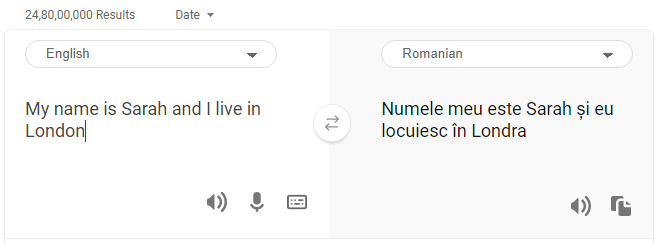

